<p align="center">
    <img src="https://github.com/GeostatsGuy/GeostatsPy/blob/master/TCG_color_logo.png?raw=true" width="220" height="240" />

</p>

## Data Analytics 

### Bootstrap in Python 

#### Michael Pyrcz, Associate Professor, University of Texas at Austin 

##### [Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)


### Bootstrap in Python 

Here's a simple workflow, demonstration of bootstrap for modeling workflows. This should help you get started with this important data analytics method to evaluate and integrate uncertainty in any sample statistics or model.  

#### Bootstrap

Uncertainty in the sample statistics
* one source of uncertainty is the paucity of data.
* do 200 or even less wells provide a precise (and accurate estimate) of the mean? standard deviation? skew? P13?

Would it be useful to know the uncertainty in these statistics due to limited sampling?
* what is the impact of uncertainty in the mean porosity e.g. 20%+/-2%?

**Bootstrap** is a method to assess the uncertainty in a sample statistic by repeated random sampling with replacement.

Assumptions
* sufficient, representative sampling, identical, idependent samples

Limitations
1. assumes the samples are representative 
2. assumes stationarity
3. only accounts for uncertainty due to too few samples, e.g. no uncertainty due to changes away from data
4. does not account for boundary of area of interest 
5. assumes the samples are independent
6. does not account for other local information sources

The Bootstrap Approach (Efron, 1982)

Statistical resampling procedure to calculate uncertainty in a calculated statistic from the data itself.
* Does this work?  Prove it to yourself, for uncertainty in the mean solution is standard error: 

\begin{equation}
\sigma^2_\overline{x} = \frac{\sigma^2_s}{n}
\end{equation}

Extremely powerful - could calculate uncertainty in any statistic!  e.g. P13, skew etc.
* Would not be possible access general uncertainty in any statistic without bootstrap.
* Advanced forms account for spatial information and sampling strategy (game theory and Journel’s spatial bootstrap (1993).

Steps: 

1. assemble a sample set, must be representative, reasonable to assume independence between samples

2. optional: build a cumulative distribution function (CDF)
    * may account for declustering weights, tail extrapolation
    * could use analogous data to support

3. For $\ell = 1, \ldots, L$ realizations, do the following:

    * For $i = \alpha, \ldots, n$ data, do the following:

        * Draw a random sample with replacement from the sample set or Monte Carlo simulate from the CDF (if available). 

6. Calculate a realization of the sammary statistic of interest from the $n$ samples, e.g. $m^\ell$, $\sigma^2_{\ell}$. Return to 3 for another realization.

7. Compile and summarize the $L$ realizations of the statistic of interest.

This is a very powerful method.  Let's try it out.

#### Objective 

The objective is to remove the hurdles of subsurface modeling workflow construction by providing building blocks and sufficient examples. This is not a coding class per se, but we need the ability to 'script' workflows working with numerical methods.    

#### Getting Started

Here's the steps to get setup in Python with the GeostatsPy package:

1. Install Anaconda 3 on your machine (https://www.anaconda.com/download/). 
2. From Anaconda Navigator (within Anaconda3 group), go to the environment tab, click on base (root) green arrow and open a terminal. 
3. In the terminal type: pip install geostatspy. 
4. Open Jupyter and in the top block get started by copy and pasting the code block below from this Jupyter Notebook to start using the geostatspy functionality. 

You will need to copy the data file to your working directory.  They are available here:

* Tabular data - sample_data_biased.csv at https://git.io/fh0CW

We need some standard packages. These should have been installed with Anaconda 3.

In [277]:
import numpy as np                        # ndarrys for gridded data
import pandas as pd                       # DataFrames for tabular data
import os                                 # set working directory, run executables
import matplotlib.pyplot as plt           # for plotting
import matplotlib
from scipy import stats                   # summary statistics
import math                               # trig etc.
import scipy.signal as signal             # kernel for moving window calculation
import random                             # random sampling
from scipy.stats import gaussian_kde      # for PDF calculation
from scipy.stats import t                 # Student's t distribution for analytical solution

#### Set the working directory

I always like to do this so I don't lose files and to simplify subsequent read and writes (avoid including the full address each time). 

In [2]:
os.chdir("c:/PGE383")                     # set the working directory

#### Loading Tabular Data

Here's the command to load our comma delimited data file in to a Pandas' DataFrame object.  

In [268]:
df = pd.read_csv('sample_data_biased.csv') # load our data table

Let's drop some samples so that we increase the variations in bootstrap samples for our demonstration below.

In [269]:
df = df.sample(frac = 0.2)                 # extract 50 random samples to reduce the size of the dataset   
print('Using ' + str(len(df)) + ' number of samples')

Using 58 number of samples


Visualizing the DataFrame would be useful and we already learned about these methods in this demo (https://git.io/fNgRW). 

We can preview the DataFrame by printing a slice or by utilizing the 'head' DataFrame member function (with a nice and clean format, see below). With the slice we could look at any subset of the data table and with the head command, add parameter 'n=13' to see the first 13 rows of the dataset.  

In [270]:
df.head()                                  # display first 4 samples in the table as a preview

,X,Y,Facies,Porosity,Perm
245,890,489,0,0.103176,2.846036
153,360,279,1,0.134607,9.776276
193,950,469,0,0.081717,0.681267
164,110,689,1,0.102856,4.723767
278,140,279,0,0.086697,1.240637


#### Summary Statistics for Tabular Data

The table includes X and Y coordinates (meters), Facies 1 and 0 (1 is sandstone and 0 interbedded sand and mudstone), Porosity (fraction), and permeability as Perm (mDarcy). 

There are a lot of efficient methods to calculate summary statistics from tabular data in DataFrames. The describe command provides count, mean, minimum, maximum, and quartiles all in a nice data table. We use transpose just to flip the table so that features are on the rows and the statistics are on the columns.

In [271]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
X,58.0,455.172414,268.819651,0.000000,255.000000,415.000000,635.000000,990.000000
Y,58.0,539.689655,277.417679,59.000000,284.000000,554.000000,769.000000,989.000000
Facies,58.0,0.706897,0.459161,0.000000,0.000000,1.000000,1.000000,1.000000
Porosity,58.0,0.130408,0.038279,0.058548,0.104409,0.123246,0.150355,0.220049
Perm,58.0,146.779192,369.297770,0.075819,2.907922,14.472930,50.165149,1906.662897


#### Visualizing Tabular Data with Location Maps 

It is natural to set the x and y coordinate and feature ranges manually. e.g. do you want your color bar to go from 0.05887 to 0.24230 exactly? Also, let's pick a color map for display. I heard that plasma is known to be friendly to the color blind as the color and intensity vary together (hope I got that right, it was an interesting Twitter conversation started by Matt Hall from Agile if I recall correctly). We will assume a study area of 0 to 1,000m in x and y and omit any data outside this area.

In [275]:
xmin = 0.0; xmax = 1000.0               # range of x values
ymin = 0.0; ymax = 1000.0               # range of y values
pormin = 0.05; pormax = 0.25;           # range of porosity values
permmin = 0.01; permmax = 10000
nx = 100; ny = 100; csize = 10.0
cmap = plt.cm.plasma                    # color map
cumul_prob = np.linspace(0.0,1.0,100)   # list of cumulative probabilities

Let's try out location maps, histograms and scatter plots. 

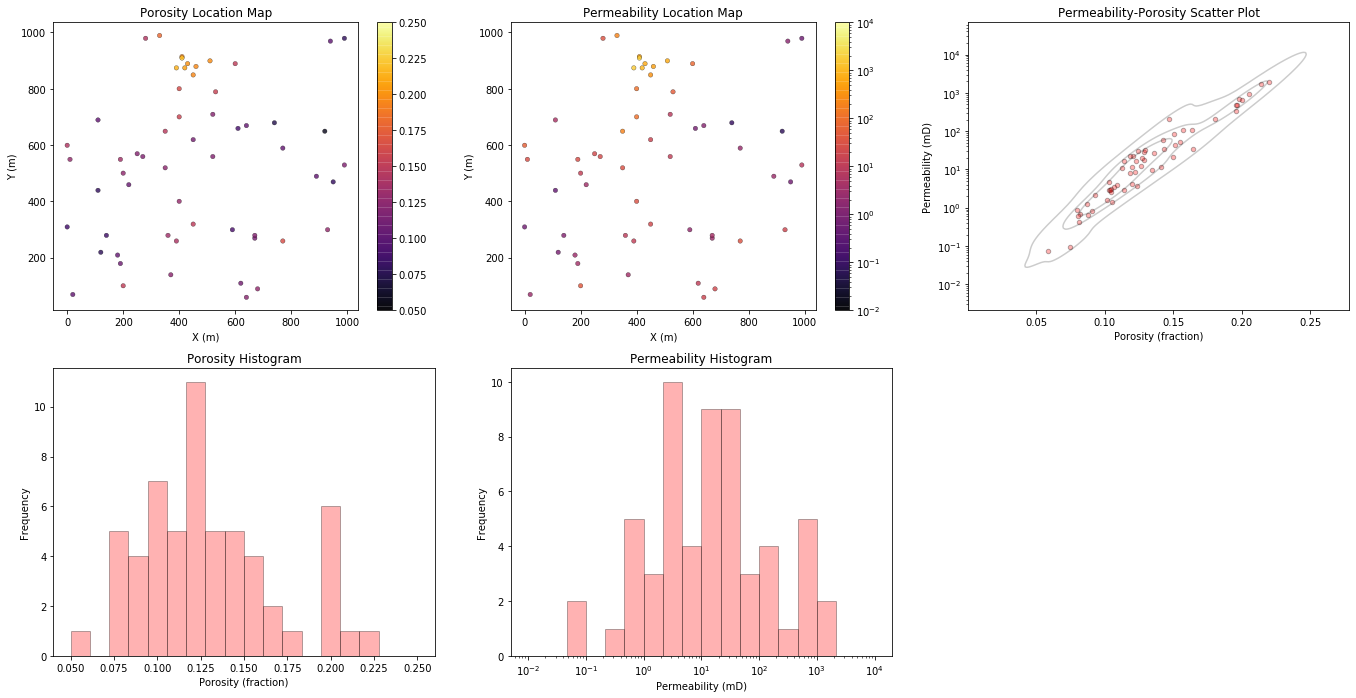

In [273]:
plt.subplot(231)
plt.scatter(df['X'],df['Y'],s = 20,c = df['Porosity'],cmap = plt.cm.inferno,linewidths = 0.3,edgecolor = 'black',alpha = 0.8,vmin = pormin,vmax = pormax)
plt.colorbar(); plt.xlabel('X (m)'); plt.ylabel('Y (m)'); plt.title('Porosity Location Map')

plt.subplot(234)
plt.hist(df['Porosity'],color = 'red',alpha = 0.3,edgecolor='black',bins = np.linspace(pormin,pormax,int(len(df)/3)))
plt.xlabel('Porosity (fraction)'); plt.ylabel('Frequency'); plt.title('Porosity Histogram')

plt.subplot(232)
plt.scatter(df['X'],df['Y'],s = 20,c = df['Perm'],cmap = plt.cm.inferno,linewidths = 0.3,edgecolor = 'black',alpha = 0.8,vmin = permmin,vmax = permmax,norm=matplotlib.colors.LogNorm())
plt.colorbar(); plt.xlabel('X (m)'); plt.ylabel('Y (m)'); plt.title('Permeability Location Map')

plt.subplot(235)
plt.hist(df['Perm'],color = 'red',alpha = 0.3,edgecolor='black',bins=np.logspace(np.log10(permmin),np.log10(permmax),int(len(df)/3)))
#sns.kdeplot(x=df['Perm'],color = 'black',alpha = 0.2,levels = 1,log_scale = True,bw_adjust = 1)
plt.xlabel('Permeability (mD)'); plt.ylabel('Frequency'); plt.title('Permeability Histogram'); plt.xscale('log')

plt.subplot(233)
plt.scatter(df['Porosity'],df['Perm'],s = 20,color = 'red',alpha = 0.3,edgecolor='black')
#plt.contour(df['Porosity'],df['Perm'] Z, colors='black');
plt.ylabel('Permeability (mD)'); plt.xlabel('Porosity (fraction)'); plt.title('Permeability-Porosity Scatter Plot')
plt.yscale('log')
sns.kdeplot(x=df['Porosity'],y=df['Perm'],color = 'black',alpha = 0.2,levels = 4)

plt.subplots_adjust(left=0.0, bottom=0.0, right=3.0, top=2.2, wspace=0.2, hspace=0.2)
plt.show()

### Bootstrap Method in Python                       

If you are new to bootstrap and Python, here's the most simple code possible for bootstrap.

* specify the number of bootstrap realizations, $L$
* declare a list to store the bootstrap realizations of the statistic of interest
* loop over L bootstrap realizations
    * n MCS, random samples with replacement for a new realization of the data
    * calculate the realization of the statistic from the realization of the data
* summarize the resulting uncertainty model, histogram, summary statistics etc.

#### Bootstrap of the Sample Mean, Arithmetic Average

Let's demonstrate bootstrap for uncertainty in the arithmetic average with a simple workflow.

```python
por_avg_real = []                      # declare an empty list to store the bootstrap realizations of the statistic 
for k in range(0,L):                   # loop over the L bootstrap realizations
    samples = random.choices(df['Porosity'].values, k=len(df)) # n Monte Carlo simulations
    por_avg_real.append(np.average(samples)) # calculate the statistic of interest from the new bootstrap dataset
```

We will compare the bootstrap results with the analytical expression:

\begin{equation}
\overline{x} \pm t_{\frac{\alpha}{2},n-1}\sqrt{\frac{s^2}{n}}
\end{equation}

The remaining code is just a super cool set of plots with the results.

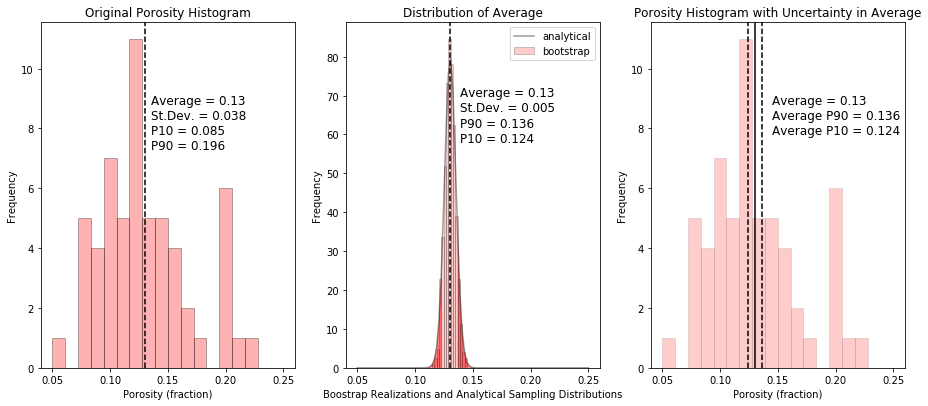

In [346]:
L = 1000                               # set the number of bootstrap realizations   
por_avg_real = []                      # declare an empty list to store the bootstrap realizations of the statistic 
for k in range(0,L):                   # loop over the L bootstrap realizations
    samples = random.choices(df['Porosity'].values, k=len(df)) # n Monte Carlo simulations
    por_avg_real.append(np.average(samples)) # calculate the statistic of interest from the new bootstrap dataset

fig = plt.subplot(131) 
plt.hist(df['Porosity'],color = 'red',alpha = 0.3,edgecolor='black',bins = np.linspace(pormin,pormax,int(len(df)/3)))
#plt.plot([np.average(df['Porosity']),np.average(df['Porosity'])],[0,100])
plt.axvline(x=np.average(df['Porosity']),linestyle="--",c='black')
plt.text(np.average(df['Porosity'])+0.005, 8.8, r'Average = ' + str(round(np.average(df['Porosity']),3)), fontsize=12)
plt.text(np.average(df['Porosity'])+0.005, 8.3, r'St.Dev. = ' + str(round(np.std(df['Porosity']),3)), fontsize=12)
plt.text(np.average(df['Porosity'])+0.005, 7.8, r'P10 = ' + str(round(np.percentile(df['Porosity'],10),3)), fontsize=12)
plt.text(np.average(df['Porosity'])+0.005, 7.3, r'P90 = ' + str(round(np.percentile(df['Porosity'],90),3)), fontsize=12)
plt.xlabel('Porosity (fraction)'); plt.ylabel('Frequency'); plt.title('Original Porosity Histogram')

plt.subplot(132)
plt.hist(por_avg_real,color = 'red',alpha = 0.2,edgecolor = 'black',bins=np.linspace(pormin,pormax,100),label = 'bootstrap',density = True) # plot the distribution, could also calculate any summary statistics
analytical = t.pdf(np.linspace(pormin,pormax,100), len(df)-1,loc=np.average(df['Porosity']),scale=math.sqrt(np.var(df['Porosity'].values)/len(df)))
plt.plot(np.linspace(pormin,pormax,100),analytical,color = 'black',label = 'analytical',alpha=0.4)
plt.axvline(x=np.average(por_avg_real),linestyle="--",c='black')
plt.fill_between(np.linspace(pormin,pormax,100), 0, analytical, where = np.linspace(pormin,pormax,100) <= np.percentile(por_avg_real,10), facecolor='red', interpolate=True, alpha = 0.5)
plt.fill_between(np.linspace(pormin,pormax,100), 0, analytical, where = np.linspace(pormin,pormax,100) >= np.percentile(por_avg_real,90), facecolor='red', interpolate=True, alpha = 0.5)
plt.text(np.average(por_avg_real)+0.009, L*0.07, r'Average = ' + str(round(np.average(por_avg_real),3)), fontsize=12)
plt.text(np.average(por_avg_real)+0.009, L*0.066, r'St.Dev. = ' + str(round(np.std(por_avg_real),3)), fontsize=12)
plt.text(np.average(por_avg_real)+0.009, L*0.062, r'P90 = ' + str(round(np.percentile(por_avg_real,90),3)), fontsize=12)
plt.text(np.average(por_avg_real)+0.009, L*0.058, r'P10 = ' + str(round(np.percentile(por_avg_real,10),3)), fontsize=12)
plt.xlabel('Boostrap Realizations and Analytical Sampling Distributions'); plt.ylabel('Frequency'); plt.title('Distribution of Average')
plt.legend()

fig = plt.subplot(133) 
plt.hist(df['Porosity'],color = 'red',alpha = 0.2,edgecolor='grey',bins = np.linspace(pormin,pormax,int(len(df)/3)))
#plt.plot([np.average(df['Porosity']),np.average(df['Porosity'])],[0,100])
plt.axvline(x=np.average(df['Porosity']),c='black')
plt.axvline(x=np.percentile(por_avg_real,90),linestyle="--",c='black')
plt.axvline(x=np.percentile(por_avg_real,10),linestyle="--",c='black')
plt.text(np.percentile(por_avg_real,90)+0.009,8.8, r'Average = ' + str(round(np.average(por_avg_real),3)), fontsize=12)
plt.text(np.percentile(por_avg_real,90)+0.009,8.3, r'Average P90 = ' + str(round(np.percentile(por_avg_real,90),3)), fontsize=12)
plt.text(np.percentile(por_avg_real,90)+0.009,7.8, r'Average P10 = ' + str(round(np.percentile(por_avg_real,10),3)), fontsize=12)
plt.xlabel('Porosity (fraction)'); plt.ylabel('Frequency'); plt.title('Porosity Histogram with Uncertainty in Average')

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.2, wspace=0.2, hspace=0.2)
plt.show()

#### Bootstrap of the Proportion

Let's demonstrate another case for which we have the analytical solution. 

We will compare the bootstrap results with the analytical expression:

\begin{equation}
\hat{p} \pm t_{\frac{\alpha}{2},n-1}\sqrt{\frac{\hat{p}(1-\hat{p})}{n}}
\end{equation}

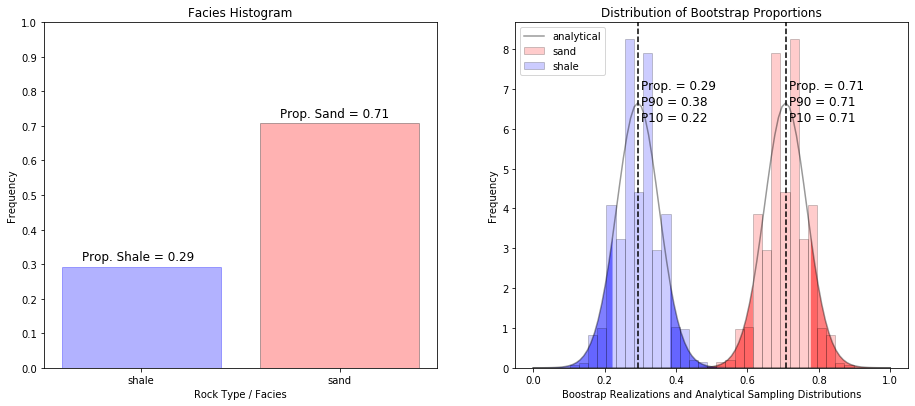

In [421]:
L = 100000                               # set the number of bootstrap realizations   
sand_prop_real = []                      # declare an empty list to store the bootstrap realizations of the statistic 
shale_prop_real = []
for k in range(0,L):                   # loop over the L bootstrap realizations
    samples = random.choices(df['Facies'].values, k=len(df)) # n Monte Carlo simulations
    sand_prop_real.append(samples.count(1)/len(df)) # calculate the statistic of interest from the new bootstrap dataset
    shale_prop_real.append(samples.count(0)/len(df)) # calculate the statistic of interest from the new bootstrap dataset       
sand_prop = np.sum(df['Facies'] == 1)/len(df); shale_prop = np.sum(df['Facies'] == 0)/len(df)

fig = plt.subplot(121) 
barlist = plt.bar(x=['shale','sand'],height = [1-sand_prop,sand_prop],color = 'red',alpha = 0.3,edgecolor='black')
barlist[0].set_color('blue')
plt.text(-.3, shale_prop+0.02, r'Prop. Shale = ' + str(round(shale_prop,2)), fontsize=12)
plt.text(0.7, sand_prop+0.02, r'Prop. Sand = ' + str(round(sand_prop,2)), fontsize=12)
plt.xlabel('Rock Type / Facies'); plt.ylabel('Frequency'); plt.title('Facies Histogram')
plt.ylim([0,1]); plt.yticks(np.arange(0, 1.1, 0.1))

plt.subplot(122)     
plt.hist(sand_prop_real,color = 'red',alpha = 0.2,edgecolor = 'black',bins=np.linspace(0.0,1.0,40),label = 'sand',density = True) # plot the distribution, could also calculate any summary statistics
analytical = t.pdf(np.linspace(0.0,1.0,100), len(df)-1,loc=sand_prop,scale=math.sqrt(sand_prop*(1.0-sand_prop)/len(df)))
plt.plot(np.linspace(0.0,1.0,100),analytical,color = 'black',label = 'analytical',alpha=0.4)
plt.axvline(x=sand_prop,linestyle="--",c='black')
plt.fill_between(np.linspace(0.0,1.0,100), 0, analytical, where = np.linspace(0.0,1.0,100) <= np.percentile(sand_prop_real,10), facecolor='red', interpolate=True, alpha = 0.5)
plt.fill_between(np.linspace(0.0,1.0,100), 0, analytical, where = np.linspace(0.0,1.0,100) >= np.percentile(sand_prop_real,90), facecolor='red', interpolate=True, alpha = 0.5)
plt.text(np.average(sand_prop_real)+0.009, 7.0, r'Prop. = ' + str(round(sand_prop,2)), fontsize=12)
plt.text(np.average(sand_prop_real)+0.009, 6.6, r'P90 = ' + str(round(np.percentile(sand_prop,90),2)), fontsize=12)
plt.text(np.average(sand_prop_real)+0.009, 6.2, r'P10 = ' + str(round(np.percentile(sand_prop,10),2)), fontsize=12)

plt.hist(shale_prop_real,color = 'blue',alpha = 0.2,edgecolor = 'black',bins=np.linspace(0.0,1.0,40),label = 'shale',density = True) # plot the distribution, could also calculate any summary statistics
analytical_shale = t.pdf(np.linspace(0.0,1.0,100), len(df)-1,loc=shale_prop,scale=math.sqrt(shale_prop*(1.0-shale_prop)/len(df)))
plt.plot(np.linspace(0.0,1.0,100),analytical_shale,color = 'black',alpha=0.4)
plt.axvline(x=shale_prop,linestyle="--",c='black')
plt.fill_between(np.linspace(0.0,1.0,100), 0, analytical_shale, where = np.linspace(0.0,1.0,100) <= np.percentile(shale_prop_real,10), facecolor='blue', interpolate=True, alpha = 0.5)
plt.fill_between(np.linspace(0.0,1.0,100), 0, analytical_shale, where = np.linspace(0.0,1.0,100) >= np.percentile(shale_prop_real,90), facecolor='blue', interpolate=True, alpha = 0.5)
plt.text(np.average(shale_prop_real)+0.009, 7.0, r'Prop. = ' + str(round(shale_prop,2)), fontsize=12)
plt.text(np.average(shale_prop_real)+0.009, 6.6, r'P90 = ' + str(round(np.percentile(shale_prop_real,90),2)), fontsize=12)
plt.text(np.average(shale_prop_real)+0.009, 6.2, r'P10 = ' + str(round(np.percentile(shale_prop_real,10),2)), fontsize=12)


plt.xlabel('Boostrap Realizations and Analytical Sampling Distributions'); plt.ylabel('Frequency'); plt.title('Distribution of Bootstrap Proportions')
plt.legend(loc = 'upper left')

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.2, wspace=0.2, hspace=0.2)
plt.show()

#### Bootstrap of the Interquartile Range

To prove that we can bootstrap any statistic let's select a more complicated measure of dispersion, the interquartile range.

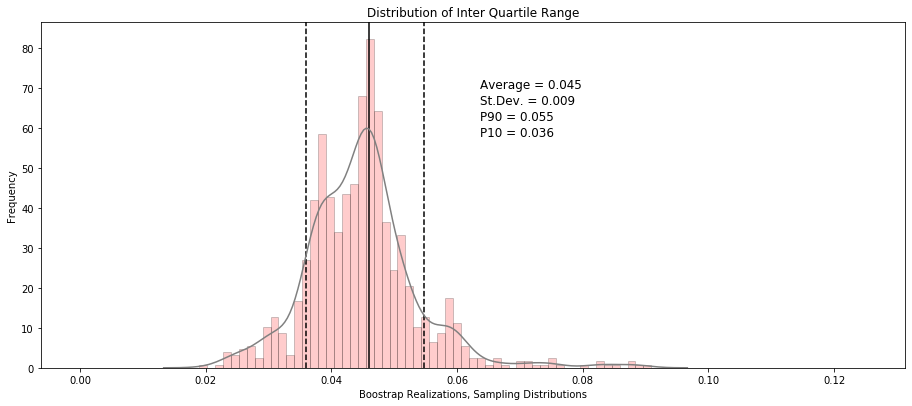

In [439]:
L = 1000                               # set the number of bootstrap realizations   
iqr_real = []                      # declare an empty list to store the bootstrap realizations of the statistic 
for k in range(0,L):                   # loop over the L bootstrap realizations
    samples = random.choices(df['Porosity'].values, k=len(df)) # n Monte Carlo simulations
    iqr_real.append(np.percentile(samples,75) - np.percentile(samples,25)) # calculate the statistic of interest from the new bootstrap dataset

iqr = np.percentile(df['Porosity'],75) - np.percentile(df['Porosity'],25)

plt.subplot(111)
plt.hist(iqr_real,color = 'red',alpha = 0.2,edgecolor = 'black',bins=np.linspace(0.0,0.125,100),label = 'bootstrap',density = True) # plot the distribution, could also calculate any summary statistics
plt.axvline(x=iqr,c='black')
plt.axvline(x=np.percentile(iqr_real,10),linestyle="--",c='black')
plt.axvline(x=np.percentile(iqr_real,90),linestyle="--",c='black')
sns.kdeplot(x=iqr_real,color = 'grey',alpha = 0.1,levels = 1,bw_adjust = 1)
plt.text(np.percentile(iqr_real,90)+0.009, L*0.07, r'Average = ' + str(round(np.average(iqr_real),3)), fontsize=12)
plt.text(np.percentile(iqr_real,90)+0.009, L*0.066, r'St.Dev. = ' + str(round(np.std(iqr_real),3)), fontsize=12)
plt.text(np.percentile(iqr_real,90)+0.009, L*0.062, r'P90 = ' + str(round(np.percentile(iqr_real,90),3)), fontsize=12)
plt.text(np.percentile(iqr_real,90)+0.009, L*0.058, r'P10 = ' + str(round(np.percentile(iqr_real,10),3)), fontsize=12)
plt.xlabel('Boostrap Realizations, Sampling Distributions'); plt.ylabel('Frequency'); plt.title('Distribution of Inter Quartile Range')
# plt.legend()

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.2, wspace=0.2, hspace=0.2)
plt.show()

#### Bootstrap of the Coefficient of Variation

Here's another statistic that requires multiple measures from the each bootstrap realization of the data.

* this reinforces that we bootstrap dataset realizations and then calculate the statistic on this dataset realization

For the coefficient of variation we will:
    
* calculate a bootstrap realization of the dataset with $n$ samples with replacement
* calculate the mean and standard deviation from this bootstrapped realization of the dataset
* calculate a boostrap realization of the coefficient of variation as the standard deviation divided by the mean

Repeat this $L$ times and then evaluate the resulting distribution.

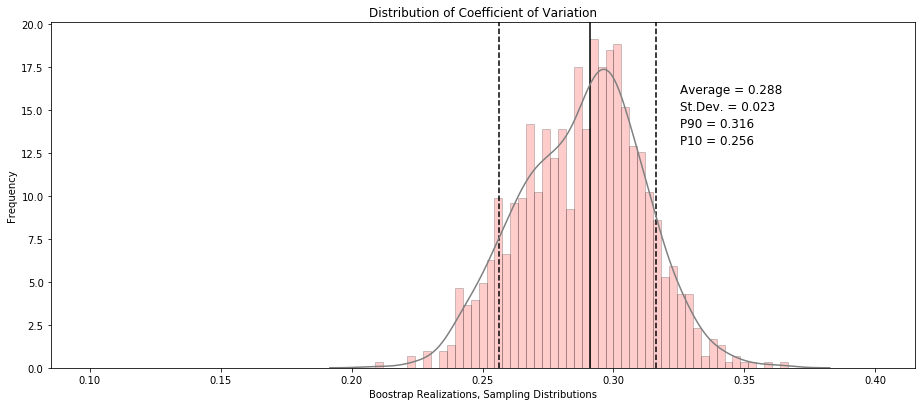

In [456]:
L = 1000                               # set the number of bootstrap realizations   
cv_real = []                      # declare an empty list to store the bootstrap realizations of the statistic 

for k in range(0,L):                   # loop over the L bootstrap realizations
    samples = random.choices(df['Porosity'].values, k=len(df)) # n Monte Carlo simulations
    cv_real.append(np.std(samples)/np.average(samples)) # calculate the statistic of interest from the new bootstrap dataset

cv = np.std(df['Porosity'])/np.average(df['Porosity'])

plt.subplot(111)
plt.hist(cv_real,color = 'red',alpha = 0.2,edgecolor = 'black',bins=np.linspace(0.1,0.4,100),label = 'bootstrap',density = True) # plot the distribution, could also calculate any summary statistics
plt.axvline(x=cv,c='black')
plt.axvline(x=np.percentile(cv_real,10),linestyle="--",c='black')
plt.axvline(x=np.percentile(cv_real,90),linestyle="--",c='black')
sns.kdeplot(x=cv_real,color = 'grey',alpha = 0.1,levels = 1,bw_adjust = 1)
plt.text(np.percentile(cv_real,90)+0.009, 16, r'Average = ' + str(round(np.average(cv_real),3)), fontsize=12)
plt.text(np.percentile(cv_real,90)+0.009, 15, r'St.Dev. = ' + str(round(np.std(cv_real),3)), fontsize=12)
plt.text(np.percentile(cv_real,90)+0.009, 14, r'P90 = ' + str(round(np.percentile(cv_real,90),3)), fontsize=12)
plt.text(np.percentile(cv_real,90)+0.009, 13, r'P10 = ' + str(round(np.percentile(cv_real,10),3)), fontsize=12)
plt.xlabel('Boostrap Realizations, Sampling Distributions'); plt.ylabel('Frequency'); plt.title('Distribution of Coefficient of Variation')
# plt.legend()

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.2, wspace=0.2, hspace=0.2)
plt.show()

#### Comments

This was a basic demonstration of bootstrap. 

* you can use bootstrap to calculate uncertainty in any statistic!

* you are calculating a set of realizations of the statistic, representing uncertainty due to small sample size

* note the assumptions of bootstrap, including stationarity and representativity

* remember, get a dataset realization by bootstrap and then calculate the realization of the statistic from the dataset realization

* if your statistic has multiple inputs (e.g. P25 and P75), calculate each from the same bootstrap realization of the dataset.

I have other demonstrations on the basics of working with DataFrames, ndarrays, univariate statistics, plotting data, declustering, data transformations, trend modeling and many other workflows available at https://github.com/GeostatsGuy/PythonNumericalDemos and https://github.com/GeostatsGuy/GeostatsPy. 
  
I hope this was helpful,

*Michael*

#### The Author:

### Michael Pyrcz, Associate Professor, University of Texas at Austin 
*Novel Data Analytics, Geostatistics and Machine Learning Subsurface Solutions*

With over 17 years of experience in subsurface consulting, research and development, Michael has returned to academia driven by his passion for teaching and enthusiasm for enhancing engineers' and geoscientists' impact in subsurface resource development. 

For more about Michael check out these links:

#### [Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)

#### Want to Work Together?

I hope this content is helpful to those that want to learn more about subsurface modeling, data analytics and machine learning. Students and working professionals are welcome to participate.

* Want to invite me to visit your company for training, mentoring, project review, workflow design and / or consulting? I'd be happy to drop by and work with you! 

* Interested in partnering, supporting my graduate student research or my Subsurface Data Analytics and Machine Learning consortium (co-PIs including Profs. Foster, Torres-Verdin and van Oort)? My research combines data analytics, stochastic modeling and machine learning theory with practice to develop novel methods and workflows to add value. We are solving challenging subsurface problems!

* I can be reached at mpyrcz@austin.utexas.edu.

I'm always happy to discuss,

*Michael*

Michael Pyrcz, Ph.D., P.Eng. Associate Professor The Hildebrand Department of Petroleum and Geosystems Engineering, Bureau of Economic Geology, The Jackson School of Geosciences, The University of Texas at Austin

#### More Resources Available at: [Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)
